# Comparison of Isomap versions on swiss roll
### (neighbours from sklearn vs neighbours from pynndescent)

In [63]:
import sys
from pprint import pprint
sys.path.append('../')

In [64]:
from typing import Union, Callable, Optional
import warnings
import torch
import torch.nn.functional as F
import pynndescent
from scipy.spatial import distance

from paradime import relationdata
from paradime import relations
from paradime import transforms
from paradime import dr
from paradime.types import BinaryTensorFun, TensorLike
Transform = Union[transforms.RelationTransform, list[transforms.RelationTransform]]
from paradime import utils
import paradime
from matplotlib import pyplot as plt
import numpy as np
import sklearn.datasets

In [65]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

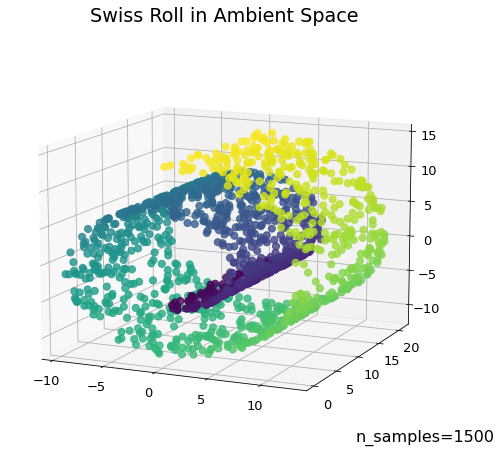

In [66]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)


In [67]:
data = sr_points
sr_points.shape

(1500, 3)

In [68]:
data

array([[ -8.85708287,   9.38265973,  -4.38885338],
       [  5.0569229 ,  17.57679767, -10.2760021 ],
       [ -5.88799247,   4.65830464,  -8.56459157],
       ...,
       [  5.02792391,   6.7958879 ,  -2.831356  ],
       [  1.98714514,  17.08444537,  -4.70959971],
       [  5.75356613,  14.64540795,   3.73357428]])

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)
scaled

array([[-1.69459265, -0.20903421, -0.70210566],
       [ 0.47118982,  1.13663354, -1.52698988],
       [-1.23243934, -0.98488304, -1.28719374],
       ...,
       [ 0.46667598, -0.63384222, -0.48387523],
       [-0.00663598,  1.05577786, -0.74704738],
       [ 0.57962571,  0.65523127,  0.43597709]])

In [70]:
data = scaled

In [71]:
# isomap of paradime with the neighbours of sklearn
paradime.utils.seed.seed_all(42);
def mse(a, b):
    return torch.sum((a - b) ** 2)

pd_isomap = paradime.dr.ParametricDR(
    model=torch.nn.Linear(3, 2, bias=False),
    global_relations=paradime.relations.GeodesicDist(radius=3, n_neighbors=None,
        
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap.add_training_phase(
    epochs=300,
    batch_size=int(len(data)/2),
    batches_per_epoch=2,
    learning_rate=0.1,
    report_interval=50,
)

pd_isomap.add_training_phase(
    epochs=250,
    batch_size=int(len(data)/2),
    batches_per_epoch=2,
    learning_rate=0.01,
    report_interval=50,
)


pd_isomap.train(data)

2023-02-05 18:41:26,476: Initializing training dataset.
2023-02-05 18:41:26,479: Computing global relations 'rel'.
2023-02-05 18:41:26,481: Calculating geodesic distances.
2023-02-05 18:41:30,736: Beginning training phase 'None'.
2023-02-05 18:41:30,827: Loss after epoch 0: 1676847.0
2023-02-05 18:41:35,368: Loss after epoch 50: 394044.328125
2023-02-05 18:41:39,777: Loss after epoch 100: 393029.953125
2023-02-05 18:41:44,196: Loss after epoch 150: 391953.875
2023-02-05 18:41:50,016: Loss after epoch 200: 393698.03125
2023-02-05 18:41:55,814: Loss after epoch 250: 393580.109375
2023-02-05 18:42:00,897: Beginning training phase 'None'.
2023-02-05 18:42:01,005: Loss after epoch 0: 394047.828125
2023-02-05 18:42:06,695: Loss after epoch 50: 392217.765625
2023-02-05 18:42:11,804: Loss after epoch 100: 392495.109375
2023-02-05 18:42:17,246: Loss after epoch 150: 393608.5
2023-02-05 18:42:22,687: Loss after epoch 200: 393485.578125


In [72]:
# new isomap of paradime with neighbours of pynndescent
paradime.utils.seed.seed_all(42);
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap_new = paradime.dr.ParametricDR(
    model=torch.nn.Linear(3, 2, bias=False), 
    global_relations=paradime.relations.GeodesicDistNew(n_neighbors=50,
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)
pd_isomap_new.add_training_phase(
    epochs=400,
    batch_size=len(data),
    learning_rate=0.1,
    report_interval=50,
)

pd_isomap_new.add_training_phase(
    epochs=400,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)


pd_isomap_new.train(data)

2023-02-05 18:42:27,707: Initializing training dataset.
2023-02-05 18:42:27,708: Computing global relations 'rel'.
2023-02-05 18:42:27,710: Calculating geodesic distances.
2023-02-05 18:42:31,424: Beginning training phase 'None'.
2023-02-05 18:42:31,645: Loss after epoch 0: 9592510.0
2023-02-05 18:42:41,921: Loss after epoch 50: 1422347.0
2023-02-05 18:42:51,798: Loss after epoch 100: 1398252.875
2023-02-05 18:43:01,693: Loss after epoch 150: 1397693.75
2023-02-05 18:43:11,768: Loss after epoch 200: 1397665.0
2023-02-05 18:43:22,173: Loss after epoch 250: 1397662.75
2023-02-05 18:43:32,671: Loss after epoch 300: 1397662.875
2023-02-05 18:43:42,776: Loss after epoch 350: 1397662.75
2023-02-05 18:43:52,869: Beginning training phase 'None'.
2023-02-05 18:43:53,080: Loss after epoch 0: 1397662.75
2023-02-05 18:44:03,711: Loss after epoch 50: 1397666.5
2023-02-05 18:44:14,193: Loss after epoch 100: 1397662.75
2023-02-05 18:44:24,936: Loss after epoch 150: 1397666.375
2023-02-05 18:44:35,063

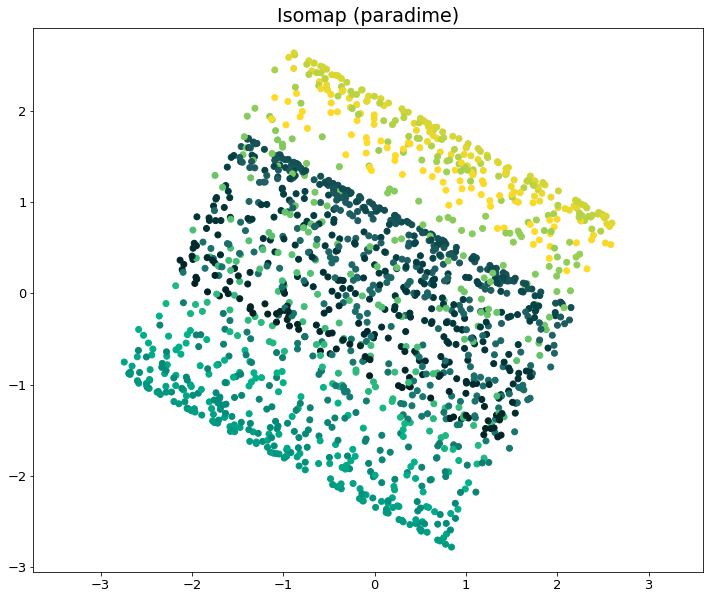

In [73]:
isomap_matrix = pd_isomap.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=sr_color,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime)");

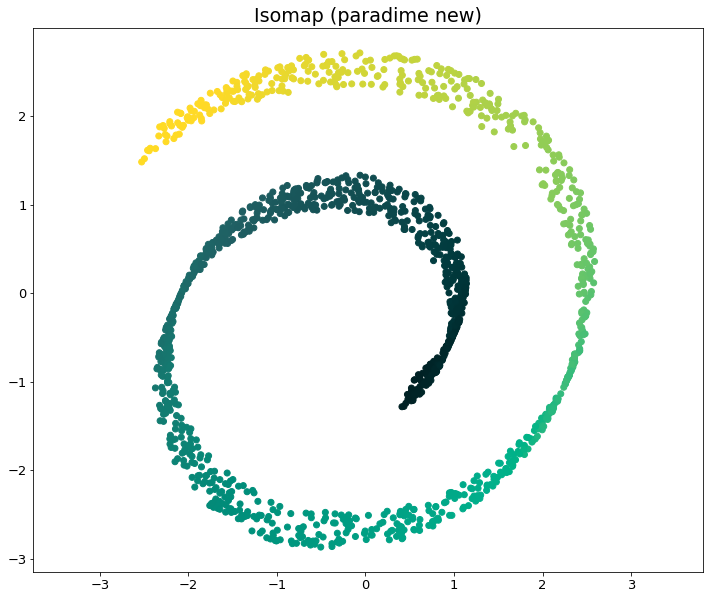

In [74]:
isomap_matrix_new = pd_isomap_new.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(
    *np.stack([np.dot(isomap_matrix_new, i) for i in data]).T,
    c=sr_color,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime new)");

## Compare with the Isomap of sklearn

In [75]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2, n_neighbors=5)
X_transformed = embedding.fit_transform(data)

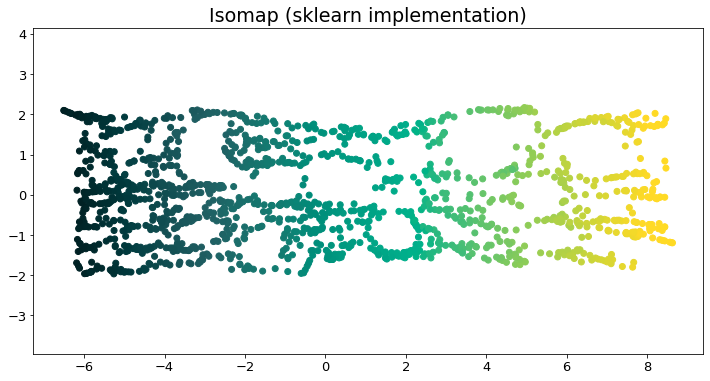

In [76]:
plt.figure(figsize=(12, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=sr_color, cmap=paradime.utils.plotting.get_colormap())
plt.title("Isomap (sklearn implementation)")
plt.axis('equal')
plt.show()

### comparison plot

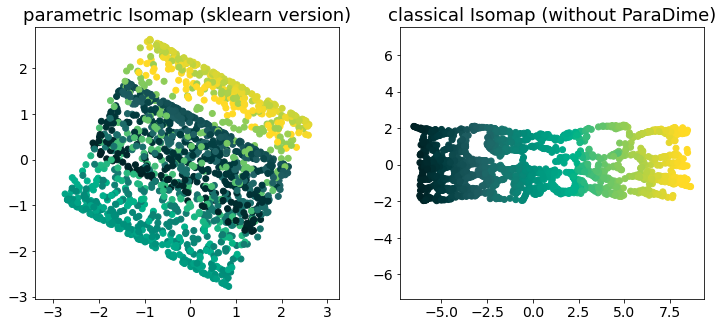

In [80]:
cmap = paradime.utils.plotting.get_colormap()
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=sr_color,
    cmap=cmap,
)



ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], c=sr_color, cmap=paradime.utils.plotting.get_colormap())
ax2.set_title("classical Isomap (without ParaDime)")
ax2.axis('equal')
ax1.axis('equal')
ax1.set_title("parametric Isomap (sklearn version)");